# Intelligent Agents: Vacuum-cleaner World


## Instructions

Total Points: undergrad 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square is cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To starte, the agent is placed on a random square.

__Actuators:__ The agent can `clean` the current square or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [25]:
from numpy import random
import numpy as np
from copy import copy, deepcopy

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
import bisect
actions = ["north", "east", "west", "south", "suck"]


def simple_randomized_agent(bumpers, dirty):
    return random.choice(actions)

In [2]:
simple_randomized_agent({"north" : True, "east" : False, "south" : False, "west" : True}, True)

'north'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

This simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns the performance measure which is here the number of cleaned squares (since all squares are constantly dirty, it is the number of `suck` actions by the agent). 

In [3]:
from numpy import random
from pprint import pprint
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0
    
    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck"): 
            num_cleaned = num_cleaned + 1
        
    return num_cleaned

#simple_environment(simple_randomized_agent, max_steps = 10000,  verbose = False)

Do one simulation run with 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: north
step 1 - action: suck
step 2 - action: south
step 3 - action: east
step 4 - action: west
step 5 - action: north
step 6 - action: suck
step 7 - action: west
step 8 - action: north
step 9 - action: suck
step 10 - action: south
step 11 - action: suck
step 12 - action: west
step 13 - action: east
step 14 - action: north
step 15 - action: west
step 16 - action: north
step 17 - action: suck
step 18 - action: west
step 19 - action: south


5

# Tasks

_Submission Instructions:_ Use this notebook to prepare your submission. Complete this section with your code and results. You can add additional Markdown blocks for your description, comments in the code and use mathplotlib to produce charts. 

_Note:_ Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design. 


## Task 1: Implement a simulation environment [2 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty.
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment needs to work with the simple randomized agent program from above and then it can be used for your agent implementation in the tasks below.

In [5]:
def environment(agent, max_steps, verbose = True, length = 5, width = 5, room = '', dirty_count = 0):
    #local variables used to keep track of the room and the agent
    num_cleaned = 0
    possiblyDirty = [False, False, False, False, True]
    
    #establish the room    
    x_location = random.randint(length)
    y_location = random.randint(width)
    if room == '':
        room = [[]] * length
        for x in range(length):
            room[x] = [False] * width
            for y in range(width):
                room[x][y] = random.choice(possiblyDirty)
                if(room[x][y]):
                    dirty_count = dirty_count + 1

        
            
    if (verbose):
        print('The room is set up')
        print(f"There is {dirty_count} dirty sqaures")
        print(f"The room size is {length}X{width}")
        print(f"The robot is {x_location},{y_location}")
        print(f"Starting actions")
        print(f"_______________________________________")
        
    #start making actions
    for i in range(max_steps):
        #set up the agents percepts
        dirty = room[x_location][y_location]
        bumpers = {"north" : y_location == 0, 
                   "south" : y_location == length - 1, 
                   "west" : x_location == 0, 
                   "east" : x_location == width - 1}
        if(verbose):
            print(f"the agent percives {dirty}, with bumpers: {bumpers}")
            print(f"\t and is in {x_location},{y_location}")
        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck" and dirty): 
            num_cleaned = num_cleaned + 1
            dirty_count = dirty_count - 1
            room[x_location][y_location] = False
        elif (action == "east"):
            x_location  = min(width - 1, x_location + 1)
        elif (action == "west"):
            x_location  = max(0, x_location - 1)
        elif (action == "south"):
            y_location  = min(length -1, y_location + 1)
        elif (action == "north"):
            y_location  = max(0, y_location - 1)
        if(verbose):
            print(f"{x_location},{y_location},{dirty}")
            print(f"*****")
            print(f"Step {i} dirty tiles {dirty_count}")
        #check if the room is clean 
        if(dirty_count == 0):
            return i
    return max_steps + 1

# Test the Random Agent on this envirnment

In [181]:
#environment(simple_randomized_agent, 1000, verbose = True, length = 5, width = 5, room = '', dirty_count = 0)

## Task 2:  Implement a simple reflex agent [1 Point] 

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking.

In [7]:
def simple_reflex_agent(bumpers, dirty):
    movements = []
    if dirty:
        return 'suck'
    if bumpers['north'] == False:
        movements.append('north')
    if bumpers['south'] == False:
        movements.append('south')
    if bumpers['east'] == False:
        movements.append('east')
    if bumpers['west'] == False:
        movements.append('west')
    return random.choice(movements)

#just some unit tests all should return true
print(simple_reflex_agent({'north': False, 'south': False, 'west': True, 'east': False}, True) == 'suck')
print(simple_reflex_agent({'north': False, 'south': True, 'west': True, 'east': True}, False) == 'north')
print(simple_reflex_agent({'north': True, 'south': False, 'west': True, 'east': True}, False) == 'south')
print(simple_reflex_agent({'north': True, 'south': True, 'west': True, 'east': False}, False) == 'east')
print(simple_reflex_agent({'north': True, 'south': True, 'west': False, 'east': True}, False) == 'west')

True
True
True
True
True


# Test this Agent on the Above Envirnment

In [183]:

#environment(simple_reflex_agent, max_steps = 1000, verbose=True)

## Task 3: Implement a model-based reflex agent [3 Point]

This agent keeps track of the location and remembers where it has cleaned. Assume the agent knows how many squares the room has. It can move to a corner to determin its location and then is able to use more advanced navigation.

_Note on implementing the state:_ You can use a global variable. In Python, you have to use the keyword `global` in your function for this to work (see: https://www.programiz.com/python-programming/global-keyword). Alternatively, you can define a class for your agent with a member variable for the state and a function for the agent program (see: https://www.w3schools.com/python/python_classes.asp). 

Describe how you define the __agent state__ and how your agent works before implementing it.

In [9]:
# Phases of the algorithm
# 1. Find a western wall, suck on the way and only move right. 
# 2. Find the Nothern corner suck on the way and only move up.
# 3. Move East till it hits a western wall
# 4. Move south 1
# 5. Move West till hits a wall
# 6. Move south 1 and move to pahse 3

In [10]:
class model_agent:
    def __init__(self):
        self.phase = 1
    def act(self, bumpers, dirt):
        if dirt:
            return 'suck'
        if self.phase == 1:
            return self.phase1(bumpers, dirt)
        elif self.phase == 2:
            return self.phase2(bumpers, dirt)
        elif self.phase == 3:
            return self.phase3(bumpers, dirt)
        elif self.phase == 4:
            return self.phase4(bumpers, dirt)
        elif self.phase == 5:
            return self.phase5(bumpers, dirt)
        elif self.phase == 6:
            return self.phase6(bumpers, dirt)
        return 'DONE'
    
    # in all the functions below it can be assumed the tile the vacuum is on is clean
    def phase1(self, bumpers, dirt):
        if bumpers['west'] == True:
            self.phase = self.phase + 1
            return self.act(bumpers, dirt)
        else:
            return 'west'
    def phase2(self, bumpers, dirt):
        if bumpers['north'] == True:
            self.phase = self.phase + 1
            return self.act(bumpers, dirt)
        else:
            return 'north'
    def phase3(self, bumpers, dirt):
        if bumpers['east'] == True:
            self.phase = self.phase + 1
            return self.act(bumpers, dirt)
        else:
            return 'east'
    def phase4(self, bumpers, dirt):
        self.phase = self.phase + 1
        return 'south'
    def phase5(self, bumpers, dirt):
        if bumpers['west'] == True:
            self.phase = self.phase + 1
            return self.act(bumpers, dirt)
        else:
            return 'west'
    def phase6(self, bumpers, dirt):
        self.phase = 3
        return 'south'


# Test the  Agent on the environment

In [184]:

agent = model_agent()
#environment(agent.act, max_steps=50, verbose=True)

## Task 4: Simulation study [3 Points]

Compare the performance of the agents using different size environments. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use at least 100 random runs for each. Present the results in a suitable format (tables, graphs) and discuss the differences.

# A Simulation function

In [12]:
def simulation(width, length, numberOfRuns, max_steps = 1000, verbose = False, inner_verbose = False):
    index = []
    simple_randomized_agent_array = []
    simple_reflex_agent_array = []
    model_agent_out_array = []
    num_dirty_array = []
    for i in range(numberOfRuns):
        ma = model_agent()
        dirty_count = 0
        possiblyDirty = [False, False, False, False, True]
        room = [[]] * length
        for x in range(length):
            room[x] = [False] * width
            for y in range(width):
                room[x][y] = random.choice(possiblyDirty)
                if(room[x][y]):
                    dirty_count = dirty_count + 1
        room2 = deepcopy(room)
        room3 = deepcopy(room)

        simple_randomized_agent_out = environment(simple_randomized_agent, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room,
                    dirty_count = dirty_count) 
        simple_reflex_agent_out = environment(simple_reflex_agent, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room2,
                    dirty_count = dirty_count) 
        model_agent_out = environment(ma.act, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room3,
                    dirty_count = dirty_count) 
        index.append(i)
        num_dirty_array.append(dirty_count)
        simple_randomized_agent_array.append(simple_randomized_agent_out)
        simple_reflex_agent_array.append(simple_reflex_agent_out)
        model_agent_out_array.append(model_agent_out)
        if(verbose):
            print(f"Random: {simple_randomized_agent_out} \t Reflex: {simple_reflex_agent_out} \t Model: {model_agent_out}")
    
    df = pd.DataFrame({'index':index,
                      'randomized_agent':simple_randomized_agent_array,
                      'reflex_agent':simple_reflex_agent_array,
                      'model_agent':model_agent_out_array,
                      'num_dirty': num_dirty_array})
    return df
    


# Test the simulation 

In [41]:
df = simulation(5,5,5, max_steps= 1000000, verbose = False, inner_verbose = False)
print(df)

   index  randomized_agent  reflex_agent  model_agent  num_dirty
0      0               614           136           33          6
1      1               772           117           16          3
2      2               126           156           24          1
3      3               518           146           31          6
4      4                84           113           23          3


# Analyze the Simulation with Many Variables

In [14]:
#These are helper functions for us to use later
def plotDataFrameAll(df, title = ''):
    ax = df.plot(kind='scatter',
             y='randomized_agent',
             x='index',
             color='blue', 
             label='randomized_agent',
             alpha=0.5)
    df.plot(kind='scatter',
             y='reflex_agent',
             x='index',
             color='red',
             figsize=(20,5), ax = ax, 
             label='reflex_agent',
             alpha=0.5)
    df.plot(kind='scatter',
             y='model_agent',
             x='index',
             color='yellow',
             figsize=(20,5), ax = ax, 
             label='model_agent',
             alpha=0.5)
    ax.set_title(title)
    
def plotDataFrameRelfexModel(df, title = ''):
    ax = df.plot(kind='scatter',
             y='reflex_agent',
             x='index',
             color='red',
             figsize=(20,5), 
             label='reflex_agent',
             alpha=0.5)
    df.plot(kind='scatter',
             y='model_agent',
             x='index',
             color='yellow',
             figsize=(20,5), ax = ax, 
             label='model_agent',
             alpha=0.5)
    ax.set_title(title)
def plotDataFrameModel(df, title = ''):
    ax = df.plot(kind='scatter',
             y='model_agent',
             x='index',
             color='red',
             figsize=(20,5), 
             label='model_agent')
    ax.set_title(title)

# Run 5 X 5 for More Cases

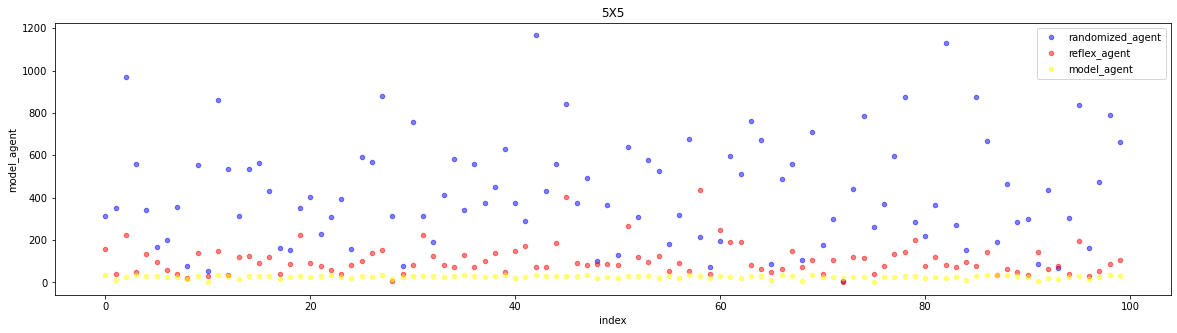

In [15]:
df5X5 = simulation(5,5,100, max_steps= 1000000, verbose = False, inner_verbose = False)
plotDataFrameAll(df5X5, '5X5')

Here we can see the clear advatange the model based agent gets.  The pure random anget really performs slowly. Below we will look at just the model vs reflex 5X5

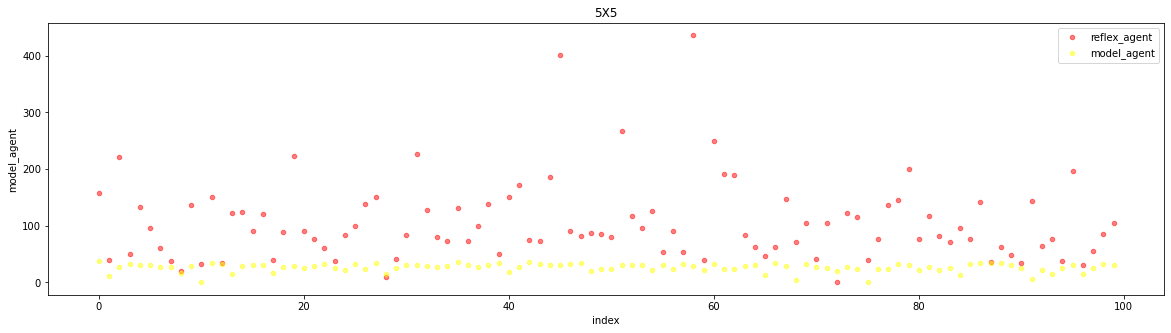

In [16]:
plotDataFrameRelfexModel(df5X5, '5X5')

Above gives a zoomed in picture of this comparison.  We see the model agent outperforming the reflex agent more often that not.  As the grid expands we will continue to look at this relationship.  It will become less and less likely for the random reflex agent to beat the model based agent.

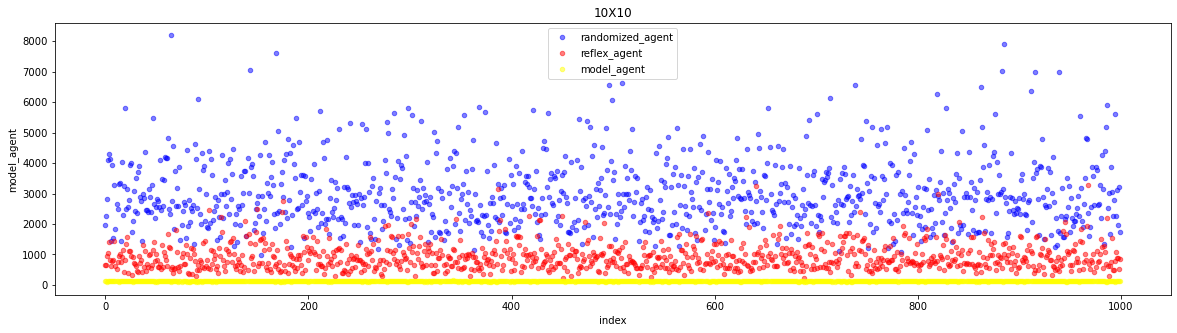

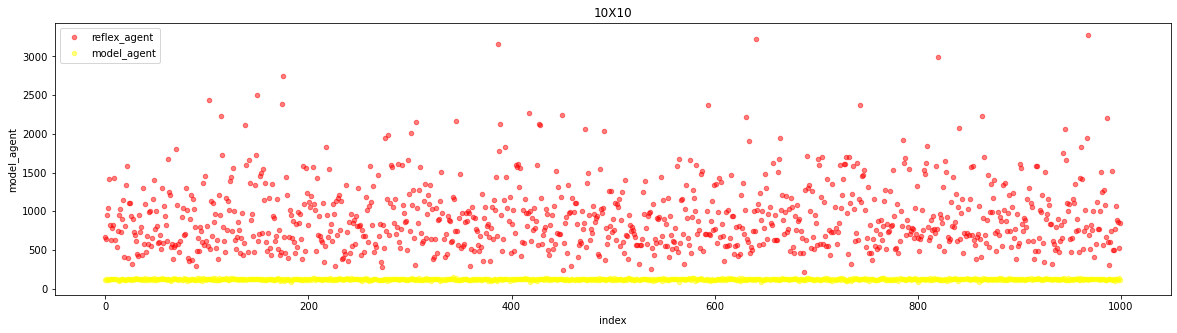

In [17]:
df10X10 = simulation(10,10,1000, max_steps= 1000000, verbose = False, inner_verbose = False)
plotDataFrameAll(df10X10, '10X10')
plotDataFrameRelfexModel(df10X10, '10X10')

We can see the random does occasionally beat the model based agent.  I theorize that the larger the grid the increasingly less likely that will happen and for a large (100X100) this will likely never happen.

In [101]:
df100X100 = simulation(100,100,100, max_steps= 1000000, verbose = False, inner_verbose = False)


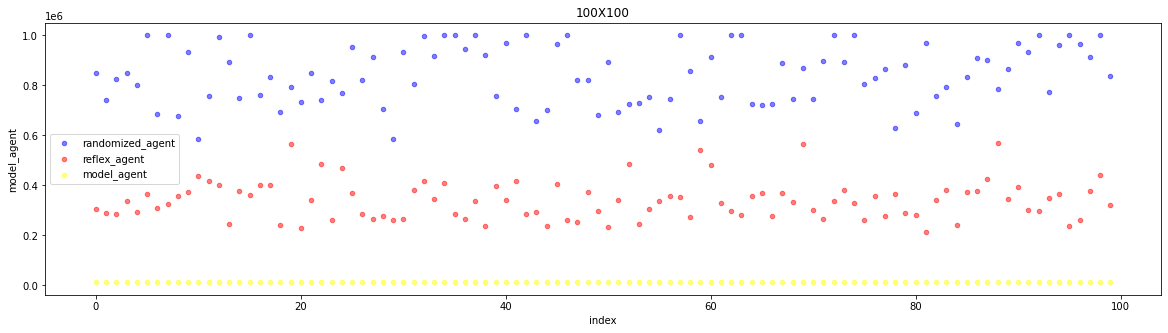

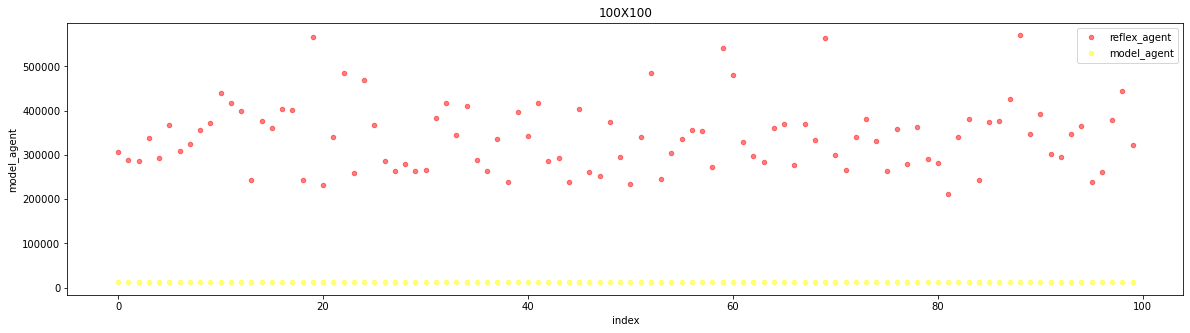

In [102]:
plotDataFrameAll(df100X100, '100X100')
plotDataFrameRelfexModel(df100X100, '100X100')

As we expected with this agent the model based agent never gets beat by the simple reflex agent.  Upon Simple analysis this makes sense.  the model based agent will touch every square about 1 time (exaclty one if it starts in the corner), and then also clean every dirty square.  This will take (# of tiles) + (amount of dirt) actions.  While the simple reflex agent must randomly travel to the tiles with dirt and suck up the dirt.

In [103]:
print('Size \tRandom Agent \tSimple Reflex \tModel Agent')
print(f"5X5 \t{df5X5['randomized_agent'].mean()}\t\t{df5X5['reflex_agent'].mean()}\t\t{df5X5['model_agent'].mean()}")
print(f"10X10 \t{df10X10['randomized_agent'].mean()}\t{df10X10['reflex_agent'].mean()}\t\t{df10X10['model_agent'].mean()}")
print(f"100X100 {df100X100['randomized_agent'].mean()}\t{df100X100['reflex_agent'].mean()}\t{df100X100['model_agent'].mean()}")


Size 	Random Agent 	Simple Reflex 	Model Agent
5X5 	425.85		104.49		26.43
10X10 	3013.237	928.321		122.027
100X100 840000.42	340529.36	12089.0


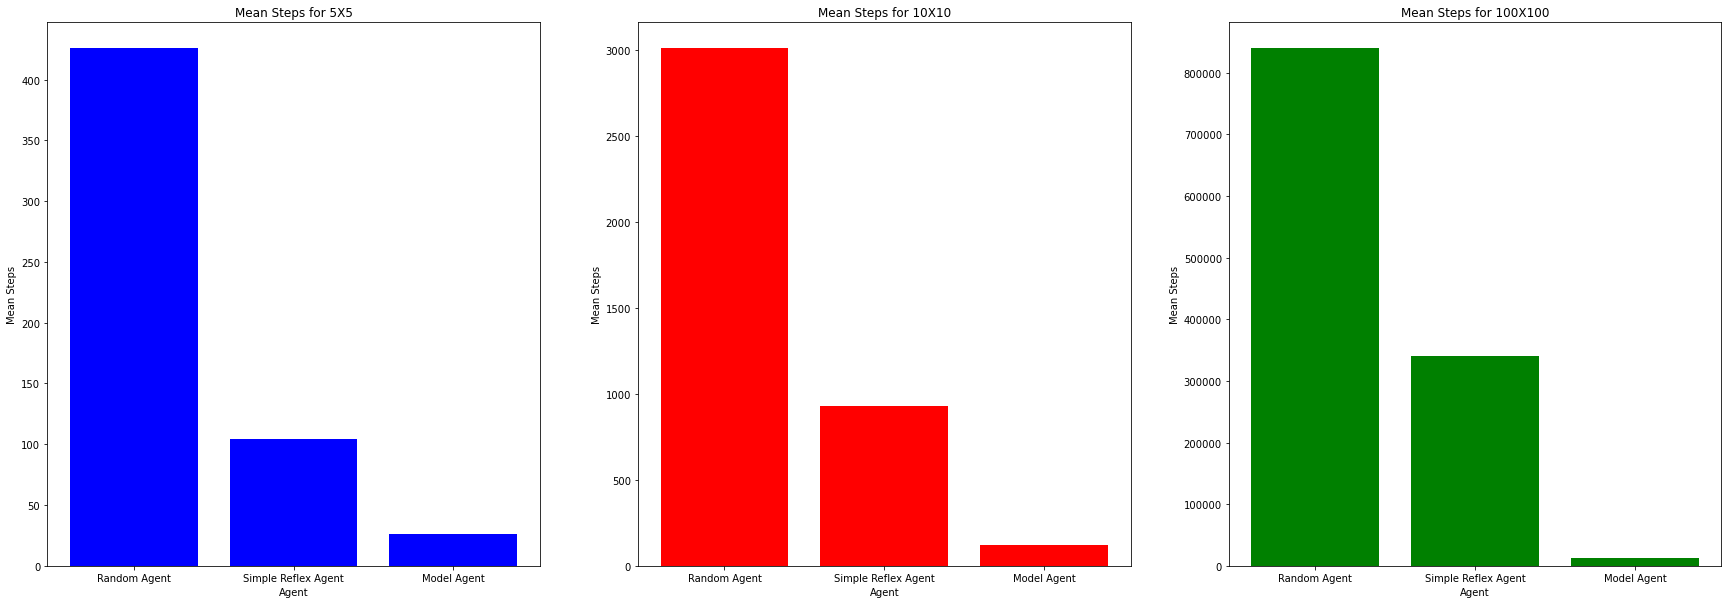

In [170]:
# First plot
x = ['Random Agent', 'Simple Reflex Agent', 'Model Agent']
y = [df5X5['randomized_agent'].mean(),df5X5['reflex_agent'].mean(),df5X5['model_agent'].mean()]

x_pos = [i for i, _ in enumerate(x)]
plt.figure(figsize=(30,10))
plt.subplot(1, 3, 1)
plt.bar(x_pos, y, color='blue')
plt.xlabel("Agent")
plt.ylabel("Mean Steps")
plt.title("Mean Steps for 5X5")
plt.xticks(x_pos, x)

#second plot
x = ['Random Agent', 'Simple Reflex Agent', 'Model Agent']
y = [df10X10['randomized_agent'].mean(),df10X10['reflex_agent'].mean(),df10X10['model_agent'].mean()]
x_pos = [i for i, _ in enumerate(x)]
plt.subplot(1, 3, 2)
plt.bar(x_pos, y, color='Red')
plt.xlabel("Agent")
plt.ylabel("Mean Steps")
plt.title("Mean Steps for 10X10")
plt.xticks(x_pos, x)

#third  plot
x = ['Random Agent', 'Simple Reflex Agent', 'Model Agent']
y = [df100X100['randomized_agent'].mean(),df100X100['reflex_agent'].mean(),df100X100['model_agent'].mean()]
x_pos = [i for i, _ in enumerate(x)]
plt.subplot(1, 3, 3)
plt.bar(x_pos, y, color='Green')
plt.xlabel("Agent")
plt.ylabel("Mean Steps")
plt.title("Mean Steps for 100X100")


plt.xticks(x_pos, x)
plt.show()

These above averages help to exemplify the efficiency differences between these agents.  The random agent performing very poorly and in some cases not completing the task (see above charts) and the model agent by far the least amount of actions for all the cases.

## Task 5: Robustness of the agent implementations [1 Point] 

Describe how your agent implementations will perform 

* if it is put into a rectangular room with unknown size,
 * While the room of rectangle size doesn't change the problem much the simple random agent will have a harder time the higher the wall to tile ratio is.  This is due to the increased chance the agent spends time moving into a wall and not moving.
 * The simple reflex agent and model based agent will be un affected by this.
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or 
 * Irregular shapes would not affect the random agents.  They would still have their downsides.
 * The model based agent could and would fail often depending on the irregularities.  In the hallway example the agent would skip over the hallway and not notice it being there.  there may be room for a more robust model based agent.
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).
 * The Random agent  wouldn't really have an affect.  It would still go on skipping over squares that need to be cleaned and walking into walls for more than one action.  In fact the agent may spend more time walking into obstacles since there is more than just a wall.
 * This simple reflex agent will avoid obsticles right in front of it and clean the squares that it encounters with dirt.  This is better than the random agent. 
 * unfortunatly this agent will likely fail to clean the room with obstacles.  With these the agent assumed an empty room and would hit an obstcle thinking it is a wall and turn around missing half a row.

## Graduate student advanced task: Obstacles [1 Point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can. 

This enviorment is constructed similarly to the envirnment above. Each tile has one of three state 'c' = clean, 'd' = dirty and 'o' = obstacle.  The wall is manually constructed this way.

In [104]:
def environment_obstacles(agent, max_steps, verbose = True, length = 5, width = 5, room = '', dirty_count = 0):
    #local variables used to keep track of the room and the agent
    num_cleaned = 0
    
    #This could be revised. but each square has a 1/20 chance to be an obstacle 
     # and a 1/10 change of being dirty 
    possibleOptions = ['o','c','c','c','c','c','c','c','c','c',
                       'd','d','c','c','c','c','c','c','c','c']
    
    
    #This allows us to set a custom room upon creation
    if room == '':
        dirty_count = 0
        room = [[]] * (length + 2)
        room[0] = ['o'] * (width + 2)
        room[length + 1] = ['o'] * (length + 2)
        for x in range(1,length + 1):
            room[x] = [''] * (width + 2)
            room[x][0] = 'o'
            for y in range(1,width + 1):
                room[x][y] = random.choice(possibleOptions)
                if(room[x][y] == 'd'):
                    dirty_count = dirty_count + 1
            room[x][length + 1] = 'o'
        room[length + 1] = ['o'] * (length + 2) 
    #place the agent   
    x_location = random.choice(range(1,length + 1))
    y_location = random.choice(range(1, width + 1))   
            
    if (verbose):
        print("room is set up, here is the room:")
        pprint(room)
        print(f"the robot is in {x_location},{y_location}")
        
    #start making actions
    for i in range(max_steps):
        #set up the agents percepts
        dirty = room[x_location][y_location] == 'd'
        bumpers = {"north" : room[x_location  ][y_location-1] == 'o', 
                   "south" : room[x_location  ][y_location+1] == 'o', 
                   "west"  : room[x_location-1][y_location  ] == 'o', 
                   "east"  : room[x_location+1][y_location  ] == 'o'}
        if(verbose):
            print(f"the agent percives {dirty}, with bumpers: {bumpers}")
            print(f"\t and is in {x_location},{y_location}")
        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck" and dirty): 
            num_cleaned = num_cleaned + 1
            dirty_count = dirty_count - 1
            room[x_location][y_location] = 'c'
        elif (action == "east" and not bumpers['east']):
            x_location  = x_location + 1
        elif (action == "west" and not bumpers['west']):
            x_location  = x_location - 1
        elif (action == "south" and not bumpers['south']):
            y_location  = y_location + 1 
        elif (action == "north" and not bumpers['north']):
            y_location = y_location - 1
        if(verbose):
            print(f"Dirty Count: {dirty_count}")
            
        #check if the room is clean 
        if(dirty_count == 0):
            if verbose:
                pprint(room)
            return i
    return max_steps + 1

In [105]:
environment_obstacles(simple_randomized_agent, 1000000, verbose = False, length = 10, width = 10, room = '', dirty_count = 0)

2286

# Simulation for the Obstacle envirment

In [106]:
def simulation_obstacles(width, length, numberOfRuns, max_steps = 1000, verbose = False, inner_verbose = False):
    index = []
    simple_randomized_agent_array = []
    simple_reflex_agent_array = []
    model_agent_out_array = []
    num_dirty_array = []   
    possibleOptions = ['o','c','c','c','c','c','c','c','c','c',
                       'd','d','d','d','c','c','c','c','c','c']
    
    
    for i in range(numberOfRuns):
        ma = model_agent()
        dirty_count = 0
        room = [[]] * (length + 2)
        room[0] = ['o'] * (width + 2)
        room[length + 1] = ['o'] * (length + 2)
        for x in range(1,length + 1):
            room[x] = [''] * (width + 2)
            room[x][0] = 'o'
            for y in range(1,width + 1):
                room[x][y] = random.choice(possibleOptions)
                if(room[x][y] == 'd'):
                    dirty_count = dirty_count + 1
            room[x][length + 1] = 'o'
        room[length + 1] = ['o'] * (length + 2)
        room2 = deepcopy(room)
        room3 = deepcopy(room)

        simple_randomized_agent_out = environment_obstacles(simple_randomized_agent, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room,
                    dirty_count = dirty_count) 
        simple_reflex_agent_out = environment_obstacles(simple_reflex_agent, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room2,
                    dirty_count = dirty_count) 
        model_agent_out = environment_obstacles(ma.act, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room3,
                    dirty_count = dirty_count) 
        index.append(i)
        num_dirty_array.append(dirty_count)
        simple_randomized_agent_array.append(simple_randomized_agent_out)
        simple_reflex_agent_array.append(simple_reflex_agent_out)
        model_agent_out_array.append(model_agent_out)
        if(verbose):
            print(f"Random: {simple_randomized_agent_out} \t Reflex: {simple_reflex_agent_out} \t Model: {model_agent_out}")
    
    df = pd.DataFrame({'index':index,
                      'randomized_agent':simple_randomized_agent_array,
                      'reflex_agent':simple_reflex_agent_array,
                      'model_agent':model_agent_out_array,
                      'num_dirty': num_dirty_array})
    return df

In [107]:
simulation_obstacles(length=5,width=5,numberOfRuns=5)

,index,randomized_agent,reflex_agent,model_agent,num_dirty
0,0,612,152,36,7
1,1,265,40,29,7
2,2,1001,44,13,2
3,3,704,52,21,3
4,4,200,77,1001,6


In [108]:
df5X5_obstacles = simulation_obstacles(length=5,width=5,numberOfRuns=1000, max_steps=100000)

In [109]:
print(df5X5_obstacles[df5X5_obstacles['model_agent'] == 100001]['model_agent'].count())
print(df5X5_obstacles[df5X5_obstacles['reflex_agent'] == 100001]['reflex_agent'].count())
print(df5X5_obstacles[df5X5_obstacles['randomized_agent'] == 100001]['randomized_agent'].count())


337
2
3


In [112]:
df10X10_obstacles = simulation_obstacles(length=10,width=10,numberOfRuns=100, max_steps=100000)

In [121]:
print(df10X10_obstacles[df10X10_obstacles['model_agent'] == 100001]['model_agent'].count())
print(df10X10_obstacles[df10X10_obstacles['reflex_agent'] == 100001]['reflex_agent'].count())
print(df10X10_obstacles[df10X10_obstacles['randomized_agent'] == 100001]['randomized_agent'].count())
df10X10_obstacles

95
1
1


,index,randomized_agent,reflex_agent,model_agent,num_dirty
0,0,2827,1270,100001,29
1,1,3816,1405,100001,24
2,2,1068,1230,100001,16
3,3,2637,1846,100001,30
4,4,2352,708,100001,22
...,...,...,...,...,...
95,95,4418,650,100001,17
96,96,4266,2029,100001,31
97,97,2506,1342,100001,23
98,98,6011,692,100001,24


In [114]:
df100X100_obstacles = simulation_obstacles(length=10,width=10,numberOfRuns=100, max_steps=1000000)

In [120]:
print(df100X100_obstacles[df100X100_obstacles['model_agent'] == 1000001]['model_agent'].count())
print(df100X100_obstacles[df100X100_obstacles['reflex_agent'] == 1000001]['reflex_agent'].count())
print(df100X100_obstacles[df100X100_obstacles['randomized_agent'] == 1000001]['randomized_agent'].count())


95
1
1


,index,randomized_agent,reflex_agent,model_agent,num_dirty
0,0,4175,1191,1000001,16
1,1,5384,702,1000001,22
2,2,3399,1142,1000001,23
3,3,2207,644,1000001,22
4,4,1000001,1000001,1000001,21
...,...,...,...,...,...
95,95,2288,2100,1000001,18
96,96,1556,570,1000001,26
97,97,2999,680,1000001,14
98,98,3301,718,1000001,26


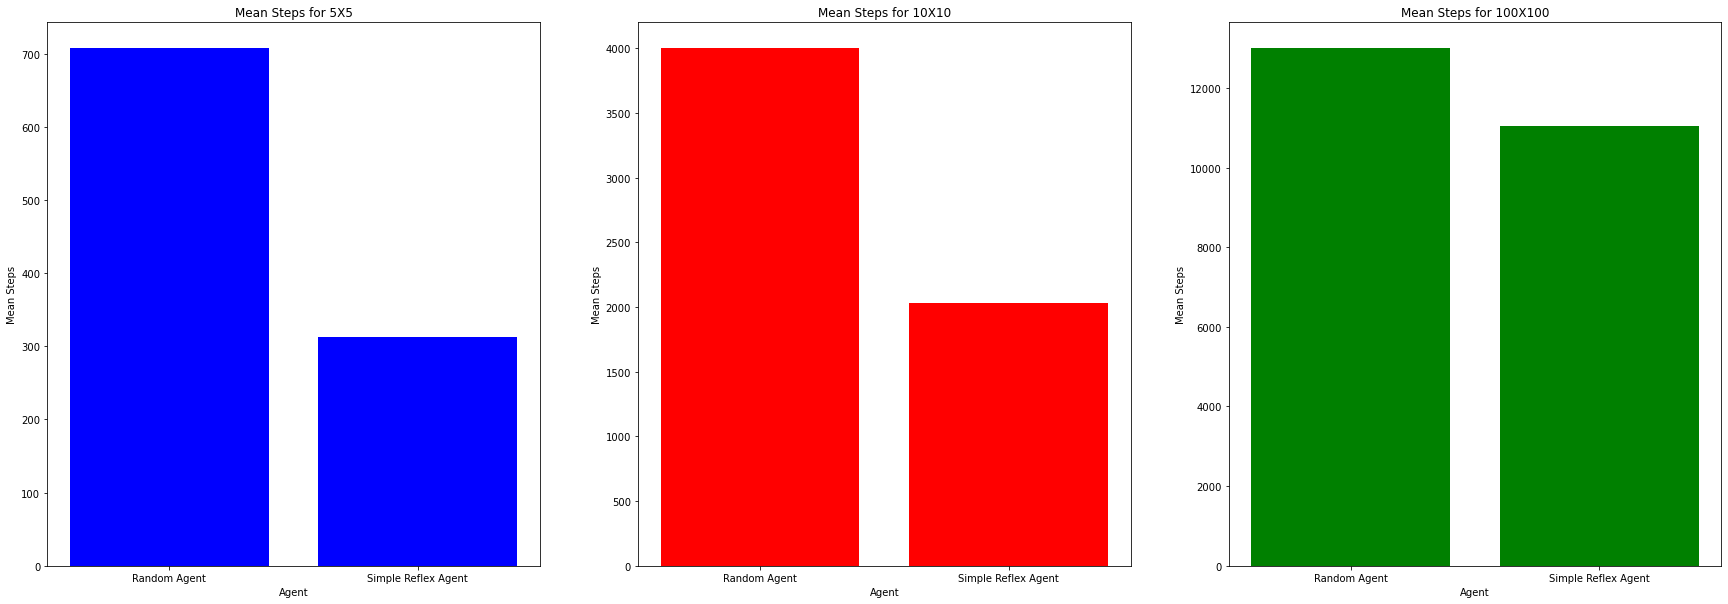

In [174]:
# First plot
x = ['Random Agent', 'Simple Reflex Agent']
y = [df5X5_obstacles['randomized_agent'].mean(),df5X5_obstacles['reflex_agent'].mean()]

x_pos = [i for i, _ in enumerate(x)]
plt.figure(figsize=(30,10))
plt.subplot(1, 3, 1)
plt.bar(x_pos, y, color='blue')
plt.xlabel("Agent")
plt.ylabel("Mean Steps")
plt.title("Mean Steps for 5X5")
plt.xticks(x_pos, x)

#second plot
x = ['Random Agent', 'Simple Reflex Agent']
y = [df10X10_obstacles['randomized_agent'].mean(),df10X10_obstacles['reflex_agent'].mean()]
x_pos = [i for i, _ in enumerate(x)]
plt.subplot(1, 3, 2)
plt.bar(x_pos, y, color='Red')
plt.xlabel("Agent")
plt.ylabel("Mean Steps")
plt.title("Mean Steps for 10X10")
plt.xticks(x_pos, x)

#third  plot
x = ['Random Agent', 'Simple Reflex Agent']
y = [df100X100_obstacles['randomized_agent'].mean(),df100X100_obstacles['reflex_agent'].mean()]
x_pos = [i for i, _ in enumerate(x)]
plt.subplot(1, 3, 3)
plt.bar(x_pos, y, color='Green')
plt.xlabel("Agent")
plt.ylabel("Mean Steps")
plt.title("Mean Steps for 100X100")


plt.xticks(x_pos, x)
plt.show()

We can see the reflex agent still out performs the random agent even if there is obstacles in the envirnment.  Below we will explore another model agent to potentially beat the random agents.

This agent is similar to the simple reflex agent.  Except it keeps track of tile that is visits.  When it is next to a tile that it has not visited it will only chose that tile.  If there is more than one it will randomly chose any one of them.

In [122]:
class simpler_model_agent:
    def __init__(self):
        self.visited = []
        self.x = 0
        self.y = 0
    def act(self, bumpers, dirt):
        if (self.x,self.y) not in self.visited:
            bisect.insort(self.visited, (self.x,self.y))
        if dirt:
            return "suck"
        choice = random.choice(self.GetDecisions(self.x, self.y, self.visited, bumpers))
        if choice == "north":
            self.y = self.y - 1
        if choice == "south":
            self.y = self.y + 1
        if choice == "east":
            self.x = self.x + 1
        if choice == "west":
            self.x = self.x - 1
        return choice
    def GetDecisions(self, x, y, visited, bumpers):
        decisions = []
        if not bumpers["north"]:
            if (x, y - 1) not in visited:
                decisions.append("north")
        if not bumpers["south"]:
            if (x, y + 1) not in visited:
                decisions.append("south")
        if not bumpers["east"]:
            if (x + 1, y) not in visited:
                decisions.append("east")
        if not bumpers["west"]:
            if (x - 1, y) not in visited:
                decisions.append("west")
        if decisions == []:
            if bumpers['north'] == False:
                decisions.append('north')
            if bumpers['south'] == False:
                decisions.append('south')
            if bumpers['east'] == False:
                decisions.append('east')
            if bumpers['west'] == False:
                decisions.append('west')
        #pprint(self.visited)
        #pprint(decisions)
        return decisions
agent2 = simpler_model_agent()
print(environment_obstacles(length=5, width=5,agent=agent2.act, max_steps=1000000, verbose=False))


16


In [123]:
agent2 = simpler_model_agent()
agent = model_agent()
print(environment_obstacles(length=100, width=100,agent=simple_reflex_agent, max_steps=1000000, verbose=False))
print(environment_obstacles(length=100, width=100,agent=agent2.act, max_steps=1000000, verbose=False))
print(environment_obstacles(length=100, width=100,agent=agent.act, max_steps=1000000, verbose=False))

296351
127215
1000001


In [124]:
def simulation_obstacles_all_agents(width, length, numberOfRuns, max_steps = 1000, verbose = False, inner_verbose = False):
    index = []
    simple_randomized_agent_array = []
    simple_reflex_agent_array = []
    model_agent_out_array = []
    simple_model_agent_out_array = []
    num_dirty_array = []   
    possibleOptions = ['o','c','c','c','c','c','c','c','c','c',
                       'd','d','d','d','c','c','c','c','c','c']
    
    
    for i in range(numberOfRuns):
        ma = model_agent()
        sma = simpler_model_agent()

        dirty_count = 0
        room = [[]] * (length + 2)
        room[0] = ['o'] * (width + 2)
        room[length + 1] = ['o'] * (length + 2)
        for x in range(1,length + 1):
            room[x] = [''] * (width + 2)
            room[x][0] = 'o'
            for y in range(1,width + 1):
                room[x][y] = random.choice(possibleOptions)
                if(room[x][y] == 'd'):
                    dirty_count = dirty_count + 1
            room[x][length + 1] = 'o'
        room[length + 1] = ['o'] * (length + 2)
        room2 = deepcopy(room)
        room3 = deepcopy(room)
        room4 = deepcopy(room)
        
        simple_randomized_agent_out = environment_obstacles(simple_randomized_agent, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room,
                    dirty_count = dirty_count) 
        simple_reflex_agent_out = environment_obstacles(simple_reflex_agent, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room2,
                    dirty_count = dirty_count) 
        model_agent_out = environment_obstacles(ma.act, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room3,
                    dirty_count = dirty_count) 
        simple_model_agent_out = environment_obstacles(sma.act, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room4,
                    dirty_count = dirty_count)
        index.append(i)
        num_dirty_array.append(dirty_count)
        simple_randomized_agent_array.append(simple_randomized_agent_out)
        simple_reflex_agent_array.append(simple_reflex_agent_out)
        model_agent_out_array.append(model_agent_out)
        simple_model_agent_out_array.append(simple_model_agent_out)
        if(verbose):
            print(f"Random: {simple_randomized_agent_out} \t Reflex: {simple_reflex_agent_out} \t Model: {model_agent_out}")
    
    df = pd.DataFrame({'index':index,
                      'randomized_agent':simple_randomized_agent_array,
                      'reflex_agent':simple_reflex_agent_array,
                      'model_agent':model_agent_out_array,
                      'simpler_model_agent':simple_model_agent_out_array,
                      'num_dirty': num_dirty_array})
    return df
simulation_obstacles_all_agents(length=100, width=100, numberOfRuns=1, max_steps=1000000, inner_verbose=False)

,index,randomized_agent,reflex_agent,model_agent,simpler_model_agent,num_dirty
0,0,852580,385495,1000001,130525,2039


In [125]:
df_final = simulation_obstacles_all_agents(length=50, width=50, numberOfRuns=100, max_steps=1000000, inner_verbose=False)

Size 	Random Agent 	Simple Reflex 	Model Agent 	Simple Model Agent
50X50 	175599.25	65407.28	1000001.0	29692.54


Text(0.5, 1.0, 'With Obstacles And New Agent')

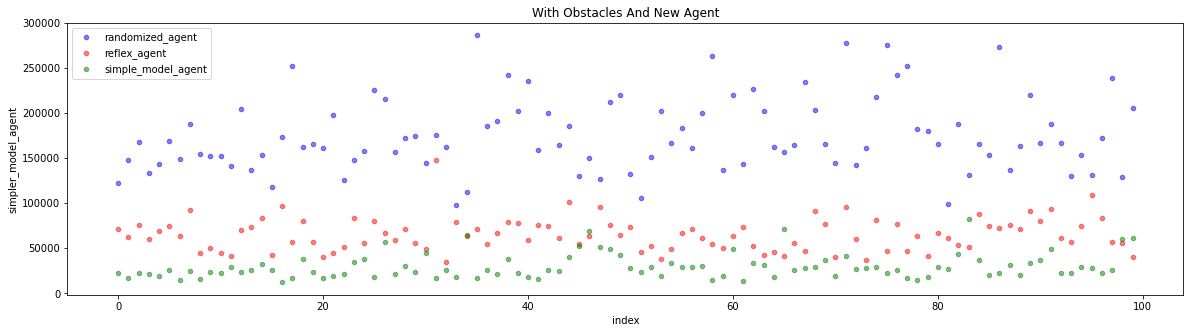

In [180]:
print('Size \tRandom Agent \tSimple Reflex \tModel Agent \tSimple Model Agent')
print(f"50X50 \t{df_final['randomized_agent'].mean()}\t{df_final['reflex_agent'].mean()}\t{df_final['model_agent'].mean()}\t{df_final['simpler_model_agent'].mean()}")

ax = df_final.plot(kind='scatter',
          y='randomized_agent',
          x='index',
          color='blue', 
          label='randomized_agent',
          alpha=0.5)
df_final.plot(kind='scatter',
          y='reflex_agent',
          x='index',
          color='red',
          figsize=(20,5), ax = ax, 
          label='reflex_agent',
          alpha=0.5)
df_final.plot(kind='scatter',
          y='simpler_model_agent',
          x='index',
          color='green',
          figsize=(20,5), ax = ax, 
          label='simple_model_agent',
          alpha=0.5)
ax.set_title('With Obstacles And New Agent')

We see the orignal model agent still hardly cleans the room.  The new model agent performs better than both the other agents extremely constently.

([<matplotlib.axis.XTick at 0x1709b02d940>,
 [Text(0, 0, 'Random Agent'),
  Text(1, 0, 'Simple Reflex Agent'),
  Text(2, 0, 'Simple Model Agent')])

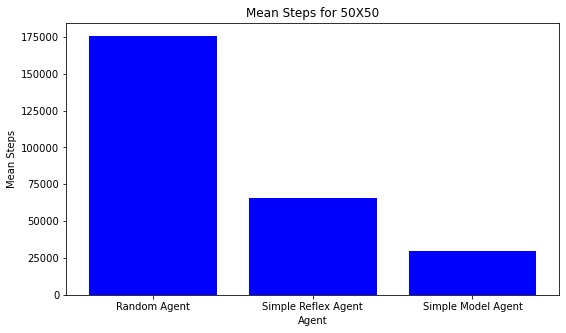

In [179]:
x = ['Random Agent', 'Simple Reflex Agent', 'Simple Model Agent']
y = [df_final['randomized_agent'].mean(),df_final['reflex_agent'].mean(),df_final['simpler_model_agent'].mean()]

x_pos = [i for i, _ in enumerate(x)]
plt.figure(figsize=(30,5))
plt.subplot(1, 3, 1)
plt.bar(x_pos, y, color='blue')
plt.xlabel("Agent")
plt.ylabel("Mean Steps")
plt.title("Mean Steps for 50X50")
plt.xticks(x_pos, x)

This new agent clearly has a use, because the previous model agent did not complete the rooms with obstacles for most rooms, whilst this new agent not only completes the room, but beats the random agents.  It could easily be possible that this agent could be expanded upon to "target" what is thinks could be a tile and move in that direction.  The downside to this, is when a tile is unreachable, it could end in an infinite loop.  

## More advanced tasks to think about

You can think about these:

* __Unknown environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square.
 * This was implemnted above.

* __Utility-based agent:__ Change the environment, so each square has a fixed probability of getting dirty again. We assume the agent has learned this information over time. For the implementation, we give this information to the agent as a 2-dimensional array of probabilities  Cleaning one dirty square produces a utility of 1. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 10000 time steps. This is very tricky!
 * The last model agent is best suited for this problem.  With a few changes and more calculation on the next more the robot could prioritize moves towards the tiles that are more likely to be dirty.  The weight function would have to consider both whether it has visited its neighbors and the density of the likelyhood highly likely dirty tiles.